lstm_staeful.py from the Official Keras examples

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GRU
#from keras.layers import Dense, LSTM, GRU
from keras.models import load_model
%matplotlib inline

/home/dgroppe/TFLOW_VE3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# EDITABLE PARAMETERS
# Read the documentation in the script head for more details
# ----------------------------------------------------------

# length of input
input_len = 1000

# The window length of the moving average used to generate
# the output from the input in the input/output pair used
# to train the LSTM
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 4

# The input sequence length that the LSTM is trained on for each output point
lahead = 3

# training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 10

In [3]:
print("*" * 33)
if lahead >= tsteps:
    print("STATELESS LSTM WILL ALSO CONVERGE")
else:
    print("STATELESS LSTM WILL NOT CONVERGE")
print("*" * 33)

np.random.seed(1986)

print('Generating Data...')


def gen_uniform_amp(amp=1, xn=10000):
    """Generates uniform random data between
    -amp and +amp
    and of length xn

    Arguments:
        amp: maximum/minimum range of uniform data
        xn: length of series
    """
    data_input = np.random.uniform(-1 * amp, +1 * amp, xn)
    data_input = pd.DataFrame(data_input)
    return data_input

*********************************
STATELESS LSTM WILL NOT CONVERGE
*********************************
Generating Data...


Input shape: (1000, 3)
Output shape: (1000, 1)
Input head: 
          0         1         2
3  0.079500  0.021696 -0.084532
4  0.008981  0.079500  0.021696
5  0.040544  0.008981  0.079500
6 -0.022773  0.040544  0.008981
7  0.030332 -0.022773  0.040544
Output head: 
          0
3  0.007610
4  0.006411
5  0.037680
6  0.026563
7  0.014271
Input tail: 
             0         1         2
998   0.003984 -0.027833  0.010251
999   0.028471  0.003984 -0.027833
1000 -0.057877  0.028471  0.003984
1001 -0.097307 -0.057877  0.028471
1002 -0.080260 -0.097307 -0.057877
Output tail: 
             0
998   0.006631
999   0.003718
1000 -0.013314
1001 -0.030682
1002 -0.051743
Plotting input and expected output


Text(0.5,1,'Input')

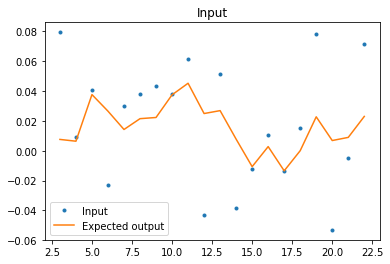

In [4]:
to_drop = max(tsteps - 1, lahead - 1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)

# set the target to be a N-point average of the input
expected_output = data_input.rolling(window=tsteps, center=False).mean()

# when lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)

# drop the nan
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

print('Input shape:', data_input.shape)
print('Output shape:', expected_output.shape)
print('Input head: ')
print(data_input.head())
print('Output head: ')
print(expected_output.head())
print('Input tail: ')
print(data_input.tail())
print('Output tail: ')
print(expected_output.tail())

print('Plotting input and expected output')
plt.plot(data_input[0][:20], '.')
plt.plot(expected_output[0][:20], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
#plt.show()

In [5]:
def create_model(stateful):
    model = Sequential()
    model.add(GRU(60,
              input_shape=(lahead, 1),
              batch_size=batch_size,
              stateful=stateful))
    #20=# of hidden units
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [6]:
# split train/test data
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    # tweak to match with batch_size
    to_train -= to_train % batch_size

    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]

    # tweak to match with batch_size
    to_drop = x.shape[0] % batch_size
    if to_drop > 0:
        x_test = x_test[:-1 * to_drop]
        y_test = y_test[:-1 * to_drop]

    # some reshaping
    print("x.shape: {}".format(x.shape))
    reshape_3 = lambda x: x.values.reshape((x.shape[0], x.shape[1], 1))
    x_train = reshape_3(x_train)
    x_test = reshape_3(x_test)

    reshape_2 = lambda x: x.values.reshape((x.shape[0], 1))
    y_train = reshape_2(y_train)
    y_test = reshape_2(y_test)

    return (x_train, y_train), (x_test, y_test)

In [7]:
(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x.shape: (1000, 3)
x_train.shape:  (800, 3, 1)
y_train.shape:  (800, 1)
x_test.shape:  (200, 3, 1)
y_test.shape:  (200, 1)


In [8]:
print('Creating Stateful Model...')
model_stateful = create_model(stateful=True)
model_fname='temp_stateful.h5'

val_loss=list()
train_loss=list()
patience=3
epochs=20

# val_loss=np.zeros(epochs)
# train_loss=np.zeros(epochs)
print('Training')
n_last_improvement=0
best_val_loss=np.nan
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    train_hist_stateful=model_stateful.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(x_test, y_test),
                       shuffle=False)
    val_loss.append(train_hist_stateful.history['val_loss'][0])
    train_loss.append(train_hist_stateful.history['loss'][0])
    if np.isnan(best_val_loss) or best_val_loss>val_loss[-1]:
        # first epoch or improved performance
        best_val_loss=val_loss[-1]
        n_last_improvement=0
        print('Best validation loss so far. Saving model as %s' % model_fname)
        model_stateful.save(model_fname)
    else:
        # No improvment
        n_last_improvement+=1
    if n_last_improvement>=patience:
        print('Validation loss not improving. EXITING!')
        break
        
    
    #val_loss[i]=train_hist_stateful.history['val_loss'][0]
    #train_loss[i]=train_hist_stateful.history['loss'][0]
    model_stateful.reset_states()

Creating Stateful Model...
Training
Epoch 1 / 20
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 4s 5ms/step - loss: 8.7197e-05 - val_loss: 5.9980e-06
Best validation loss so far. Saving model as temp_stateful.h5
Epoch 2 / 20
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 5.3993e-06 - val_loss: 2.2927e-05
Epoch 3 / 20
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 2.2625e-05 - val_loss: 1.0535e-04
Epoch 4 / 20
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 1.3174e-05 - val_loss: 5.4403e-07
Best validation loss so far. Saving model as temp_stateful.h5
Epoch 5 / 20
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 1.4499e-06 - val_loss: 7.4307e-07
Epoch 6 / 

In [ ]:
plt.figure(1)
plt.clf()
plt.plot(np.asarray(val_loss),'-o',label='val')
plt.plot(np.asarray(train_loss),'-o',label='train')
plt.legend()
print('Best valid loss {}'.format(np.min(val_loss)))

In [9]:
print('Loading best model: %s' % model_fname)
model_stateful=load_model(model_fname)
print('Predicting')
predicted_stateful = model_stateful.predict(x_test, batch_size=batch_size)

Loading best model: temp_stateful.h5
Predicting


In [10]:
predicted_stateful.shape

(200, 1)

In [ ]:
print('Creating Stateless Model...')
model_stateless = create_model(stateful=False)

epochs=5
print('Training')
train_hist_stateless=model_stateless.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

print('Predicting')
predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)

In [ ]:
print('Plotting Results')
plt.subplot(3, 1, 1)
plt.plot(y_test)
plt.title('Expected')
plt.subplot(3, 1, 2)
# drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist
plt.plot((y_test - predicted_stateful).flatten()[tsteps - 1:])
plt.title('Stateful: Expected - Predicted')
plt.subplot(3, 1, 3)
plt.plot((y_test - predicted_stateless).flatten())
plt.title('Stateless: Expected - Predicted')
#plt.show()

Plotting Results


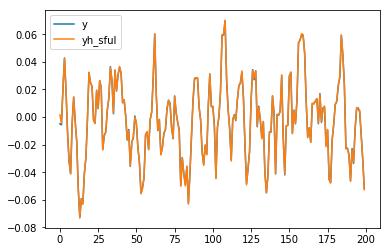

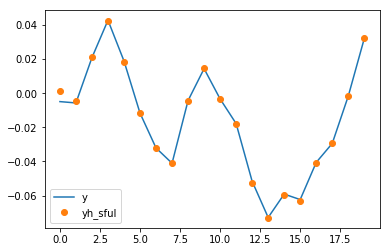

In [12]:
print('Plotting Results')
plt.figure(1)
plt.clf()
plt.plot(y_test,label='y')
plt.plot(predicted_stateful,label='yh_sful')
#plt.plot(predicted_stateless,label='yh_sless')
plt.legend()

n_show=20
plt.figure(2)
plt.clf()
plt.plot(y_test[:n_show],label='y')
plt.plot(predicted_stateful[:n_show],'o',label='yh_sful')
#plt.plot(predicted_stateless[:n_show],'o',label='yh_sless')
plt.legend()